# Experiments on real-world datasets

This notebook evaluates and plots the results of the MIA/AI analysis on the Adult and Purchase-100 datasets.
Please, refer to the individual sections for the instructions on how to run the experiments first.

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

FIGSIZE = (4, 4/1.6)
DPI = 300

In [2]:
def load_results(file_pattern):
    res = []
    for fname in glob.glob(file_pattern):
        res.append(pd.read_json(fname, lines=True))
    
    if len(res) == 1:
        return res[0]
    
    return pd.concat(res)

# Privacy vs utility

The following should be run after running:

```
$ bash launch-adult.sh
$ bash launch-purchase100.sh
```

In [3]:
results_adult = load_results("results/analysis/adult-approximate-*")
results_purchase = load_results("results/analysis/purchase100-*")

In [4]:
# We use the approximate AI analysis.
# If you would like to use the "full" AI analysis, simply don't run this
# cell, but make sure you have run `launch-adult-full.sh` instead of
# `launch-adult.sh`.
results_adult["Bayes-AI"] = results_adult["Bayes-AI-approximate"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


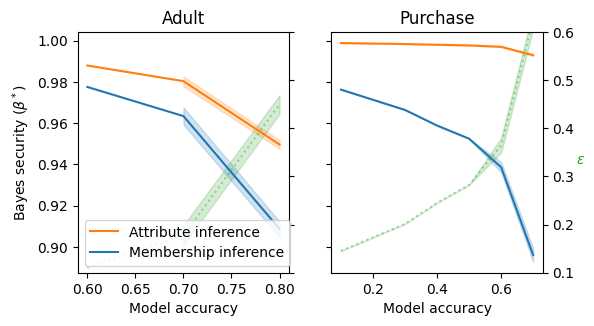

In [5]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=[1.5*FIGSIZE[0], 1.25*FIGSIZE[1]])

for i, dataset, results in zip([0, 1], ["adult", "purchase"], [results_adult, results_purchase]):
    axes[i].set_title(dataset.title())
    rounded_accuracy = results.accuracy.round(1) # Avoids jitters.

    ax = sns.lineplot(x=rounded_accuracy, y=results["Bayes-AI"], label="Attribute inference", color=sns.color_palette()[1], ax=axes[i])
    sns.lineplot(x=rounded_accuracy, y=results["Bayes-MIA"], label="Membership inference", color=sns.color_palette()[0], ax=axes[i])

    # Epsilon on other axis.
    ax2 = ax.twinx()
    sns.lineplot(x=rounded_accuracy, y=results.epsilon, ax=ax2, color=sns.color_palette()[2], alpha=0.4, ls=":")
    ax2.set_ylim([0.1, 0.6])

    ax.set_zorder(ax2.get_zorder()+1) # First plots on top.
    ax.set_frame_on(False)
    if dataset == "adult":
        ax2.set_ylabel("")
        ax2.set_yticklabels([])
    elif dataset == "purchase":
        ax2.set_ylabel(r"$\varepsilon$", color=sns.color_palette()[2], rotation=0)
        ax.legend().set_visible(False)
        ax2.legend().set_visible(False)

    ax.set_xlabel("Model accuracy")
    ax.set_ylabel(r"Bayes security ($\beta^*$)")

# Running times

The following should be run after running:

```
$ bash timing-experiments.sh
```

**NOTE** This script takes a long time to run (~8h on an A100), as it runs an exact AI analysis that computes the diamater of the set of per-sample gradients for all values of the sensitive attribute at each iteration.

In [6]:
results_no_dp = load_results("results/timing/adult-disable-dp.jsonl")
results_mia = load_results("results/timing/adult-mia.jsonl")
results_accountant = load_results("results/timing/adult-accountant.jsonl")
results_ai_approximate = load_results("results/timing/adult-ai-approximate.jsonl")
results_ai = load_results("results/timing/adult-ai.jsonl")

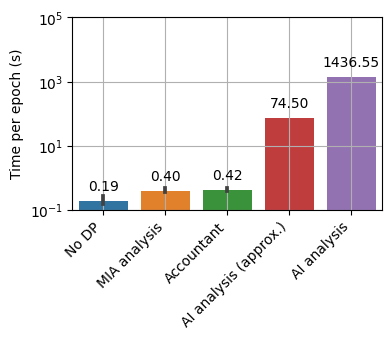

In [7]:
plt.figure(figsize=FIGSIZE)
ax = sns.barplot(pd.DataFrame({
    "No DP": results_no_dp.epoch_time,
    "MIA analysis": results_mia.epoch_time,
    "Accountant": results_accountant.epoch_time,
    "AI analysis (approx.)": results_ai_approximate.epoch_time,
    "AI analysis": results_ai.epoch_time,
}))

ax.bar_label(ax.containers[0], labels=[f'{x:.2f}' for x in ax.containers[0].datavalues], padding=5)
plt.ylabel("Time per epoch (s)")
plt.xticks(rotation=45, ha='right')
plt.yscale("log")
plt.ylim([0.1, 10**5])
plt.grid()

# AI analysis

The following should be run after running

```
$ bash launch-adult-full.sh
```

**NOTE**: the `launch-adult-full.sh` script takes a long time to run (~25h on an A100), as it tests all the values for the sensitive attribute,
rather than using the approximate algorithm.

In [8]:
results_adult = load_results("results/analysis/adult-full-*")

## Approximate AI bound estimation

How good is the approximate method?

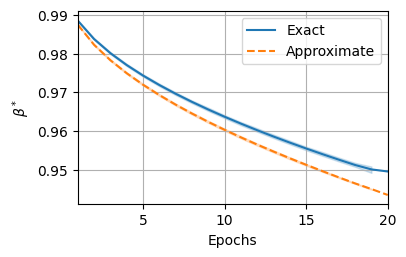

In [9]:
plt.figure(figsize=FIGSIZE)
epochs = np.arange(1, 20)
sns.lineplot(x="epoch", y="Bayes-AI", data=results_adult, label=r"Exact", ls="-")
sns.lineplot(x="epoch", y="Bayes-AI-approximate", data=results_adult, label=r"Approximate", ls="--")

plt.xlabel("Epochs")
plt.ylabel(r"$\beta^*$")
plt.legend()
plt.grid()
plt.xlim([1, 20]);

## Empirical comparison between threat models

This experiments reproduces the table on page 12 of the paper comparing AI and MI attacks in terms of Bayes security, attack success rate, and TPR at FPR $\leq$ 0.10.

Note that there is a typo in the camera-ready paper in the TPR column for the Adult dataset, where it should read 16% (20%) instead of 17% (22%).

In [10]:
results_adult = load_results("results/analysis/adult-approximate-*")
results_purchase = load_results("results/analysis/purchase100-*")

In [11]:
from IPython.display import display, Markdown

fpr = 0.10

adult_bayes_mia = results_adult[results_adult['epoch'] == 30].mean()["Bayes-MIA"]
adult_bayes_ai = results_adult[results_adult['epoch'] == 30].mean()["Bayes-AI-approximate"]

adult_tpr_mia = 1 + fpr - adult_bayes_mia
adult_tpr_ai = 1 + fpr - adult_bayes_ai
adult_acc_ai = (adult_tpr_ai + (1 - fpr)) / 2
adult_acc_mia = (adult_tpr_mia + (1 - fpr)) / 2

purchase_bayes_mia = results_purchase[results_purchase['epoch'] == 30].mean()["Bayes-MIA"]
purchase_bayes_ai = results_purchase[results_purchase['epoch'] == 30].mean()["Bayes-AI"]

purchase_tpr_mia = 1 + fpr - purchase_bayes_mia
purchase_tpr_ai = 1 + fpr - purchase_bayes_ai
purchase_acc_ai = (purchase_tpr_ai + (1 - fpr)) / 2
purchase_acc_mia = (purchase_tpr_mia + (1 - fpr)) / 2

display(Markdown(f"""
Task      | β* AI (MIA)         | Success rate AI (MIA)  | TPR AI (MIA)
----------|---------------------|------------------------|------------
Adult     | {adult_bayes_ai:.2} ({adult_bayes_mia:.2}) | {adult_acc_ai:.2} ({adult_acc_mia:.2}) | {adult_tpr_ai:.2} ({adult_tpr_mia:.2})
Purchase  | {purchase_bayes_ai:.2} ({purchase_bayes_mia:.2}) | {purchase_acc_ai:.2} ({purchase_acc_mia:.2}) | {purchase_tpr_ai:.2} ({purchase_tpr_mia:.2})
"""))


Task      | β* AI (MIA)         | Success rate AI (MIA)  | TPR AI (MIA)
----------|---------------------|------------------------|------------
Adult     | 0.93 (0.88) | 0.53 (0.56) | 0.17 (0.22)
Purchase  | 0.99 (0.87) | 0.51 (0.56) | 0.11 (0.23)
